# IMD3004 - Aprendizado Profundo

### Professor: Dr. Silvan Ferreira da Silva Junior

### Aluno: João Antonio Costa Paiva Chagas

# Laboratório 15: Custom Dataset

# Atividade: CNNs para Classificação

Neste notebook, iremos preparar nosso próprio dataset e treinar um modelo de classificação de imagens.

## Importações

In [1]:
!pip install icrawler

In [2]:
import os
import re
import sys
import torch
import shutil
import random
import logging
import numpy as np
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Preparando os dados

Os dados desta atividade serão baixados da internet. Utilizaremos para isso buscadores comuns. Em seguida, dividiremos em treinamento e validação.

### Tornando os logs mais legíveis

In [3]:
class CleanLogHandler(logging.Handler):
    def __init__(self):
        super().__init__()
        # Grupo 1 (\d+):   Código de status (ex: 403)
        # Grupo 2 ([^/]+): Domínio do site  (ex: upload.wikimedia.org)
        self.regex = re.compile(r"Response status code (\d+), file https?://([^/]+)")

    def emit(self, record):
        msg = self.format(record)

        match = self.regex.search(msg)

        if match:
            status_code = match.group(1)
            domain = match.group(2)

            if status_code == '400':
                print(f"    -> [Downloader] Falha: O site '{domain}' não entendeu a requisição (400 Bad Request).")
            elif status_code == '401':
                print(f"    -> [Downloader] Falha: O site '{domain}' requer autenticação (401 Unauthorized).")
            elif status_code == '403':
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' proibiu o acesso (403 Proibido).")
            elif status_code == '404':
                print(f"    -> [Downloader] Falha ao baixar porque a imagem no site '{domain}' não foi encontrada (404 Link Quebrado).")
            elif status_code == '406':
                print(f"    -> [Downloader] Falha: O site '{domain}' não tem um formato de resposta aceitável (406 Not Acceptable).")
            elif status_code == '429':
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' nos bloqueou por muitas requisições (429 Rate Limit).")
            elif status_code == '504':
                print(f"    -> [Downloader] Falha: O servidor do site '{domain}' demorou demais (504 Gateway Timeout).")
            else:
                # Mensagem genérica para outros códigos (400, 401, 500, etc.)
                print(f"    -> [Downloader] Falha ao baixar porque o site '{domain}' deu um erro (Código {status_code}).")

        elif "Read timed out" in msg:
            print("    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).")

        elif "CERTIFICATE_VERIFY_FAILED" in msg:
            print("    -> [Downloader] Falha ao baixar devido a um erro no certificado de segurança (SSL) do site.")

In [4]:
downloader_logger = logging.getLogger('downloader')
downloader_logger.setLevel(logging.ERROR)
downloader_logger.handlers = []
downloader_logger.addHandler(CleanLogHandler())
downloader_logger.propagate = False

### Adquirindo as Imagens

Utilizaremos o iCrawler para baixar imagens em buscadores através de termos especificados. Defina sua lista de classes.

In [5]:
def download_and_verify_images(keyword, folder, n_total=100):
    os.makedirs(folder, exist_ok=True)

    imagens_validas = 0
    file_index_offset = 0

    print(f"Baixando imagens de '{keyword}'. Alvo: {n_total} imagens válidas.")
    while imagens_validas < n_total:
        imagens_faltando = n_total - imagens_validas

        compensacao = imagens_faltando + 10

        print(f"\nAlvo: {n_total} | Válidas: {imagens_validas} | Buscando mais {compensacao}...")

        imagens_antes_do_crawl = set(os.listdir(folder))

        try:
            crawler = BingImageCrawler(storage={'root_dir': folder})
            crawler.crawl(keyword=keyword,
                          max_num=compensacao,
                          file_idx_offset=file_index_offset)
        except Exception as e:
            print(f"  -> [Crawler] Erro Inesperado: {e}. Tentando novamente...")
            time.sleep(5)
            continue

        imagens_depois_do_crawl = set(os.listdir(folder))

        novas_imagens = imagens_depois_do_crawl - imagens_antes_do_crawl

        if not novas_imagens:
            print("  -> [Crawler] Não encontrou novas imagens. Parando.")
            break


        print(f"  -> {len(novas_imagens)} baixadas. Verificando...")

        novas_imagens_validas_encontradas = 0
        for filename in novas_imagens:
            file_path = os.path.join(folder, filename)
            if not os.path.isfile(file_path):
                continue

            try:
                with Image.open(file_path) as img:
                    img.load()
                # Imagem é válida!
                novas_imagens_validas_encontradas += 1
            except (IOError, OSError, Image.UnidentifiedImageError):
                # Imagem corrompida.
                print(f"    -> Removendo imagem corrompida: {filename}")
                os.remove(file_path)

        print(f"  -> Verificação concluída: {novas_imagens_validas_encontradas} novas imagens válidas.")
        imagens_validas += novas_imagens_validas_encontradas

        # Atualiza o offset para o próximo loop, para evitar sobrescrever arquivos
        file_index_offset = len(os.listdir(folder))

    print(f"\n--- Download concluído para '{keyword}' ---")
    print(f"Total de imagens válidas na pasta: {imagens_validas}\n")

Coloquei uma compensação de 10 imagens extras, caso imagens corrompidas sejam baixadas.

In [6]:
search_terms = {
    "Obama": "Barack Obama",
    "Trump": "Donald Trump",
    "Biden": "Joe Biden",
    "Bush": "George W. Bush",
    "Clinton": "Bill Clinton",
}

for label, term in search_terms.items():
    download_and_verify_images(term, f"data/presidents/{label}", n_total=100)

Baixando imagens de 'Barack Obama'. Alvo: 100 imagens válidas.

Alvo: 100 | Válidas: 0 | Buscando mais 110...
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o site 'www.telegraph.co.uk' proibiu o acesso (403 Proibido).
  -> 17 baixadas. Verificando...
  -> Verificação concluída: 17 novas imagens válidas.

Alvo: 100 | Válidas: 17 | Buscando mais 93...
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar porque o servidor demorou demais para responder (Tempo Esgotado).
    -> [Downloader] Falha ao baixar por

### Treinamento e Validação

Dividiremos as imagens baixadas nas pastas `train` e `val`. Defina uma porcentagem.

In [7]:
def split_train_val(root_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    train_dir = root_dir + "_split/train"
    val_dir = root_dir + "_split/val"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        images = [f for f in images if os.path.isfile(f)]
        random.shuffle(images)

        n_train = int(len(images) * train_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in images[:n_train]:
            shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))
        for img in images[n_train:]:
            shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

        print(f"{class_name}: {n_train} train, {len(images)-n_train} val")

## Funções auxiliares

In [8]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        for phase, loader in [('train', train_loader), ('val', val_loader)]:
            if phase == 'train':
                model.train()  # modelo em treino
            else:
                model.eval()   # modelo em avaliação

            running_loss, running_corrects = 0.0, 0
            size = len(loader.dataset)

            loop = tqdm(loader, desc=f'{phase.capitalize()}')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    if phase == 'train':
                        # Em modo .train() retorna um objeto com 3 saídas
                        # (main_output, aux1_output, aux2_output)
                        main_output, aux1_output, aux2_output = outputs

                        loss1 = criterion(main_output, labels)
                        loss2 = criterion(aux1_output, labels)
                        loss3 = criterion(aux2_output, labels)

                        loss = loss1 + 0.3 * loss2 + 0.3 * loss3

                        _, preds = torch.max(main_output, 1)
                    else:
                        # Em modo .eval() retorna uma única saída
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, history

In [9]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

## Dataset

Implemente um Dataset PyTorch que carregue as imagens baixadas com suas respectivas classes. Aplique data augmentation e carregue em batches.

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "data/presidents"
split_train_val(data_dir)

train_dir = data_dir + "_split/train"
val_dir = data_dir + "_split/val"

image_datasets = {
    'train': ImageFolder(train_dir, data_transforms['train']),
    'val': ImageFolder(val_dir, data_transforms['val'])
}

train_dataloader = DataLoader(image_datasets['train'], batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(image_datasets['val'], batch_size=4, shuffle=False, num_workers=4)

class_names = image_datasets['train'].classes
train_size = len(image_datasets['train'])
val_size = len(image_datasets['val'])

print(f"Classes: {class_names}")
print(f"Train size: {train_size}")
print(f"Val size: {val_size}")

Obama: 81 train, 21 val
Biden: 88 train, 22 val
Bush: 88 train, 22 val
Clinton: 88 train, 22 val
Trump: 81 train, 21 val
Classes: ['Biden', 'Bush', 'Clinton', 'Obama', 'Trump']
Train size: 426
Val size: 108


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Definição do Modelo

Defina aqui o modelo que será utilizado, sendo implementação própria ou um modelo pré-treinado.

In [11]:
googlenet_pretrained = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT, aux_logits=True)

for param in googlenet_pretrained.parameters():
    param.requires_grad = False

numero_de_features = googlenet_pretrained.fc.in_features
googlenet_pretrained.fc = nn.Linear(numero_de_features, len(class_names))

num_features_aux1 = googlenet_pretrained.aux1.fc2.in_features
googlenet_pretrained.aux1.fc2 = nn.Linear(num_features_aux1, len(class_names))

num_features_aux2 = googlenet_pretrained.aux2.fc2.in_features
googlenet_pretrained.aux2.fc2 = nn.Linear(num_features_aux2, len(class_names))

for param in googlenet_pretrained.inception5b.parameters():
    param.requires_grad = True

googlenet_pretrained = googlenet_pretrained.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 173MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


## Treinamento

Defina a função de custo e o otimizador do modelo. Em seguida, implemente o código de treinamento e treine-o. Ao final, exiba as curvas de treinamento e validação para a loss e a acurácia.


Epoch 1/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 2.6901 Acc: 0.2347


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 1.3447 Acc: 0.6111

Epoch 2/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 2.4632 Acc: 0.4061


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 1.1528 Acc: 0.6019

Epoch 3/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 2.3115 Acc: 0.4601


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.9842 Acc: 0.7870

Epoch 4/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 2.2219 Acc: 0.5188


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.8898 Acc: 0.6944

Epoch 5/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 2.0658 Acc: 0.5681


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.7345 Acc: 0.8981

Epoch 6/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 2.0180 Acc: 0.5869


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.6672 Acc: 0.8889

Epoch 7/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.9412 Acc: 0.6221


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.6221 Acc: 0.8426

Epoch 8/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.9329 Acc: 0.6221


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.5875 Acc: 0.8796

Epoch 9/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.8600 Acc: 0.6643


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.4437 Acc: 0.9167

Epoch 10/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.9409 Acc: 0.6103


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.4852 Acc: 0.8796

Epoch 11/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.7735 Acc: 0.6784


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.4422 Acc: 0.9074

Epoch 12/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.8233 Acc: 0.6714


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.3820 Acc: 0.9167

Epoch 13/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.8143 Acc: 0.6667


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.3654 Acc: 0.9259

Epoch 14/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.7038 Acc: 0.6972


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.3018 Acc: 0.9352

Epoch 15/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.8879 Acc: 0.6432


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.3830 Acc: 0.8981

Epoch 16/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.6706 Acc: 0.7042


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2971 Acc: 0.9444

Epoch 17/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.7463 Acc: 0.6831


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2407 Acc: 0.9444

Epoch 18/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.6986 Acc: 0.6972


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2745 Acc: 0.9444

Epoch 19/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.6675 Acc: 0.7113


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2794 Acc: 0.9630

Epoch 20/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.6651 Acc: 0.7606


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2337 Acc: 0.9537

Epoch 21/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.6839 Acc: 0.7183


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.3024 Acc: 0.8981

Epoch 22/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.6526 Acc: 0.7277


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2293 Acc: 0.9537

Epoch 23/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.5892 Acc: 0.7488


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2344 Acc: 0.9259

Epoch 24/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.7879 Acc: 0.6808


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.2057 Acc: 0.9352

Epoch 25/25


Train:   0%|          | 0/107 [00:00<?, ?it/s]

Train Loss: 1.6654 Acc: 0.6972


Val:   0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 0.1861 Acc: 0.9722
Plots GoogLeNet


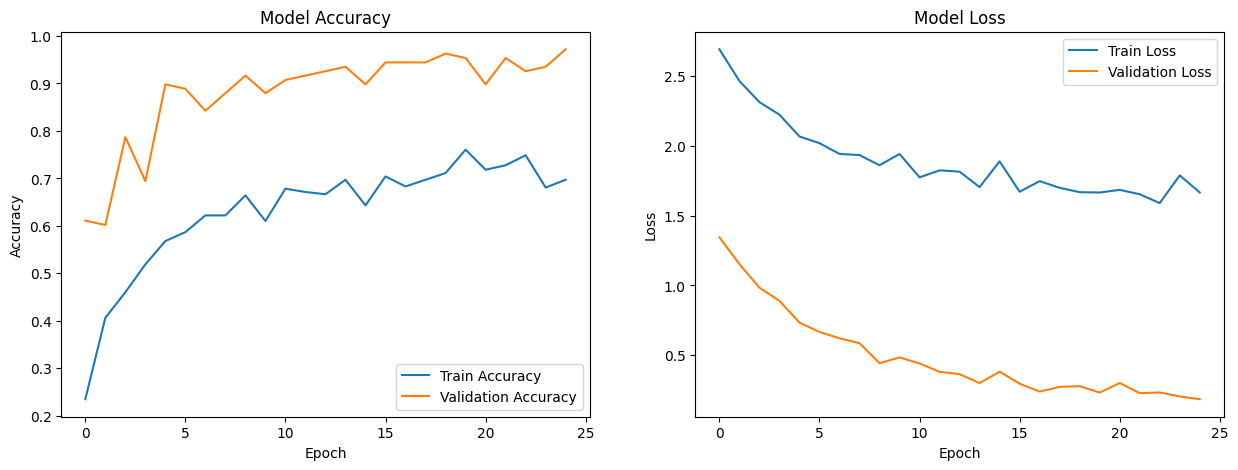

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam([
    {'params': googlenet_pretrained.fc.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.aux1.fc2.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.aux2.fc2.parameters(), 'lr': 1e-3},
    {'params': googlenet_pretrained.inception5b.parameters(), 'lr': 1e-5}
], lr=1e-3)

modelo, history_googlenet = train_model(
    googlenet_pretrained, criterion, optimizer_googlenet, train_dataloader, val_dataloader, num_epochs=25
)

print(f"Plots GoogLeNet")
plot_history(history_googlenet)

## Inferência

Calcule algumas métricas como acurácia, matriz de confusão, etc. Em seguida, teste o modelo em novas imagens das classes correspondentes mas de outras fontes (outro buscador, fotos próprias, etc).

Avaliando:   0%|          | 0/27 [00:00<?, ?it/s]


--- Relatório da Classificação ---
              precision    recall  f1-score   support

       Biden       1.00      1.00      1.00        22
        Bush       0.91      0.95      0.93        22
     Clinton       0.95      0.91      0.93        22
       Obama       1.00      1.00      1.00        21
       Trump       1.00      1.00      1.00        21

    accuracy                           0.97       108
   macro avg       0.97      0.97      0.97       108
weighted avg       0.97      0.97      0.97       108


--- Matriz de Confusão ---


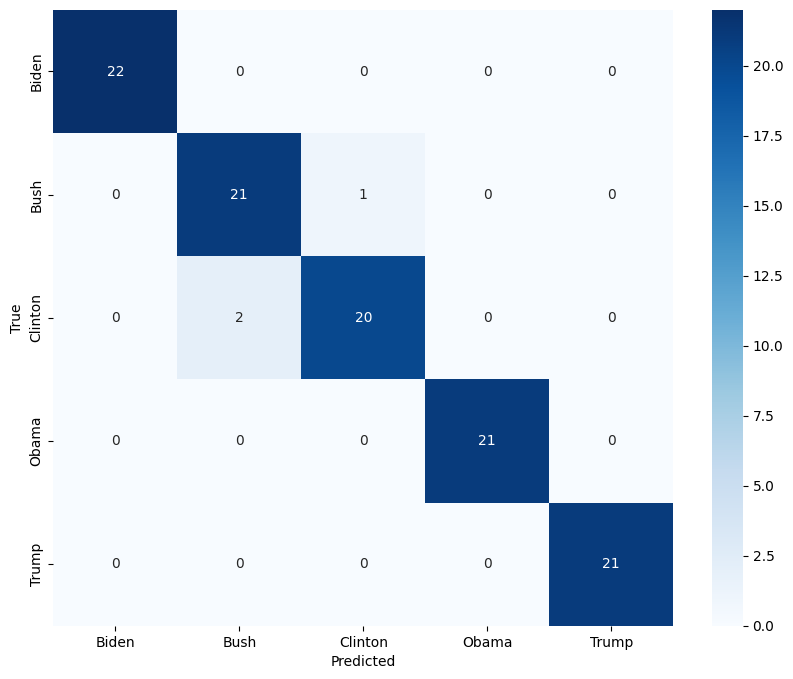

In [13]:
modelo.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in tqdm(val_dataloader, desc="Avaliando"):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = modelo(inputs)
        _, preds = torch.max(outputs, 1)

        y_pred.extend(preds.view(-1).cpu().numpy())
        y_true.extend(labels.view(-1).cpu().numpy())

print("\n--- Relatório da Classificação ---")
print(classification_report(y_true, y_pred, target_names=class_names))


print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()